In [1]:
#This notebook combines all the flat images into one master-flat image, reducing uncertainty. Statsics for this image is also gathered.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.utils.data import download_file
import os
import glob
import time
from matplotlib.colors import LogNorm
from IPython import display
from IPython.display import clear_output
import random
plt.rcParams.update({'font.size':15})

In [2]:
#Filepaths are defined for master-bias, master-dark-per-sec, and flat images:
image_list = []
n = 0

filepath = ''

biasfilepath = "master_bias.fits"
barkfilepath = "master_dark_per_sec.fits"


for file in glob.glob(filepath+"*Flat_*.fits"):
    image_list.append(file)
    n=n+1
print("\n".join(image_list))

Flat_Blue_20_secs_001.fits
Flat_Blue_20_secs_002.fits
Flat_Blue_20_secs_003.fits
Flat_Blue_20_secs_004.fits
Flat_Blue_20_secs_005.fits
Flat_Blue_20_secs_006.fits
Flat_Blue_20_secs_007.fits
Flat_Blue_20_secs_008.fits
Flat_Blue_20_secs_009.fits
Flat_Blue_20_secs_010.fits


In [3]:
image_concat = []

image_concat = [fits.getdata(image) for image in image_list]

hdu_number = 0 # HDU means header data unit
image_hdr = [fits.getheader(image, hdu_number) for image in image_list]

In [4]:
#An array is made for the flat images to analyse the statistics:
N_images = np.shape(image_concat)
print(N_images) #shape of array, imagex X y-pixels X x-pixels
print(N_images[0]) #number of images

image_concat[0]

(10, 3520, 4656)
10


array([[5696, 6016, 5776, ..., 6112, 6288, 5872],
       [5696, 6016, 5456, ..., 6160, 5024, 5760],
       [5712, 5536, 6384, ..., 5856, 6096, 5936],
       ...,
       [6528, 5984, 5808, ..., 5952, 5824, 5728],
       [6256, 5744, 5632, ..., 6064, 5920, 6320],
       [6464, 5872, 6144, ..., 5616, 5920, 6320]], dtype=uint16)

In [5]:
#ZWO camera is 12 bit, but it scales the output to 16 bit so we must divide the statistics by 16 to remove this:
for i in range(N_images[0]):
    image_concat[i] = image_concat[i] /16 
   

In [6]:
#Subtracting the master-bias from the flat images:
masterbias_image = fits.getdata(biasfilepath)

Min: 4.0
Max: 28.92
Mean: 7.257558878084966
Median 7.24
Stdev: 0.3713808000529168


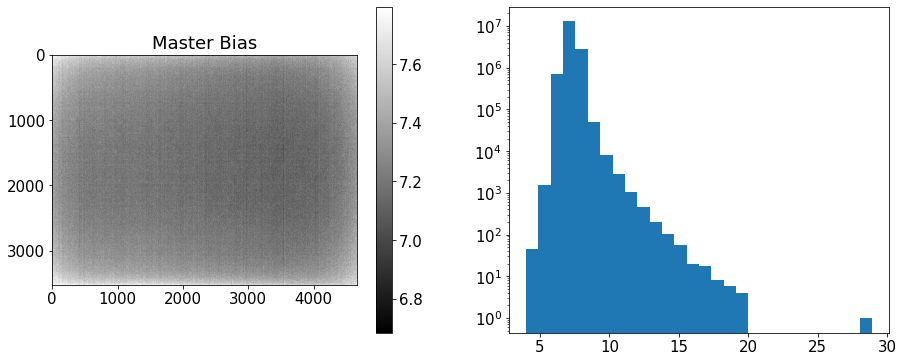

In [7]:
plt.figure(figsize=(15,6))

N_std = 1.5

print('Min:', np.min(masterbias_image) )
print('Max:', np.max(masterbias_image)  )    
print('Mean:', np.mean(masterbias_image)  )
print('Median', np.median(masterbias_image)  )
print('Stdev:', np.std(masterbias_image)  )

plt.subplot(1,2,1)
plt.imshow(masterbias_image, cmap='gray', 
               vmin= np.median(masterbias_image) - N_std*np.std(masterbias_image), vmax=np.median(masterbias_image) + N_std*np.std(masterbias_image)) 
plt.title("Master Bias")
plt.colorbar()


plt.subplot(1,2,2)
plt.hist(masterbias_image.flatten(),bins=int(np.max(masterbias_image)))
plt.yscale('log')
  
plt.show()

In [8]:
for i in range(N_images[0]):
    image_concat[i] = image_concat[i] - masterbias_image

In [9]:
#Subtracting the master-dark-per-sec image from each flat image:
masterdark_image = fits.getdata(barkfilepath)

Min: -0.4204444444444445
Max: 45.09155555555555
Mean: 0.03361856543311119
Median 0.03377777777777777
Stdev: 0.02690206761661891


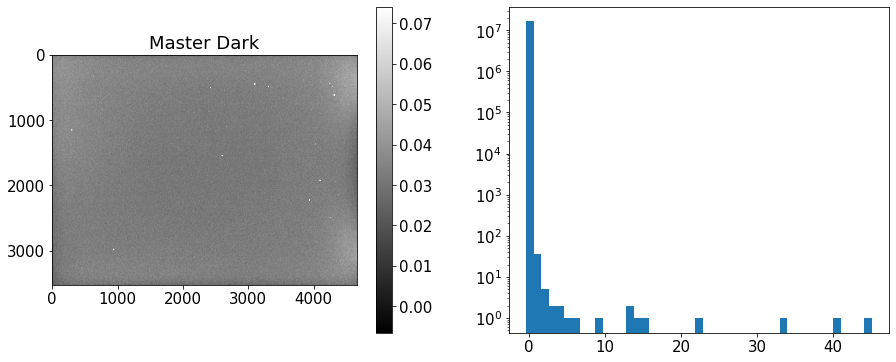

In [10]:
plt.figure(figsize=(15,6))

N_std = 1.5

print('Min:', np.min(masterdark_image) )
print('Max:', np.max(masterdark_image)  )    
print('Mean:', np.mean(masterdark_image)  )
print('Median', np.median(masterdark_image)  )
print('Stdev:', np.std(masterdark_image)  )

plt.subplot(1,2,1)
plt.imshow(masterdark_image, cmap='gray', 
               vmin= np.median(masterdark_image) - N_std*np.std(masterdark_image), vmax=np.median(masterdark_image) + N_std*np.std(masterdark_image)) 
plt.title("Master Dark")
plt.colorbar()


plt.subplot(1,2,2)
plt.hist(masterdark_image.flatten(),bins=int(np.max(masterdark_image)))
plt.yscale('log')
  
plt.show()

In [11]:
#Finding the mean exposure time out of all of the flat images to scale the master-dark-per-sec:
exposures = np.zeros(N_images[0])

for n in range(N_images[0]):
    exposures[n] = image_hdr[n]["EXPTIME "]
print(exposures)
mean_exp = np.mean(exposures)
print(mean_exp)

[20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
20.0


In [12]:
for i in range(N_images[0]):
    image_concat[i] = image_concat[i] - masterdark_image * mean_exp

In [13]:
image_hdr[0]

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4656 / length of data axis 1                          
NAXIS2  =                 3520 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'ZWO CCD ASI1600MM Pro' / CCD Name                                    
TELESCOP= 'SynScan '        

In [14]:
for n in range(N_images[0]):
    camera_temp = image_hdr[n]["CCD-TEMP"]
    print('Camera temp = ',str(camera_temp), ' C')

Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C
Camera temp =  -20.0  C


In [15]:
for n in range(N_images[0]):
    exposure = image_hdr[n]["EXPTIME "]
    print('Flat Exposure time= ',str(exposure))

Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0
Flat Exposure time=  20.0


In [16]:
#New arrays made to store the new data for master-flat:
image_min = np.zeros(N_images[0])
image_max = np.zeros(N_images[0])
image_mean = np.zeros(N_images[0])
image_median = np.zeros(N_images[0])
image_stdev = np.zeros(N_images[0])

Flat_Blue_20_secs_010.fits
Min: 91.00000000000006
Max: 3008.3555555555554
Mean: 238.8869823137409
Median 238.8
Stdev: 18.56605108297216


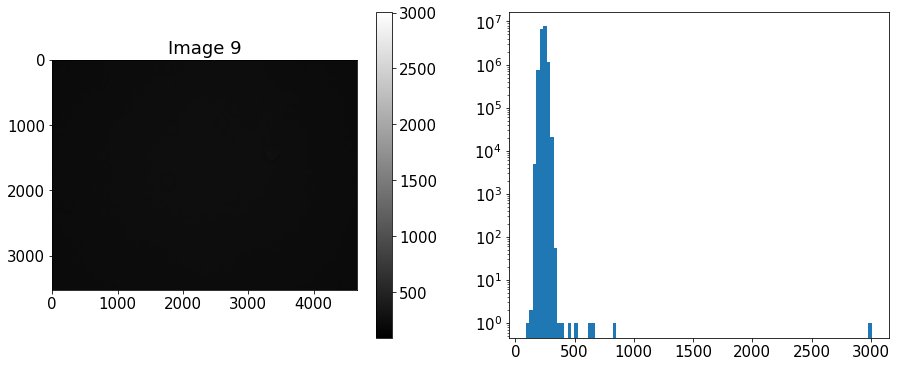

In [17]:
#Going through each flat image to find some statistics and a histogram
N_std = 0.2


for i in range(N_images[0]):
    clear_output(wait=True)

    plt.figure(figsize=(15,6))
    
    print(image_list[i])
    image_min[i] = np.min(image_concat[i])
    image_max[i] = np.max(image_concat[i])
    image_mean[i] = np.mean(image_concat[i])
    image_median[i] = np.median(image_concat[i])
    image_stdev[i] = np.std(image_concat[i])

    
    
    print('Min:', image_min[i] )
    print('Max:', image_max[i] )    
    print('Mean:', image_mean[i] )
    print('Median', image_median[i] )
    print('Stdev:', image_stdev[i] )


    
    plt.subplot(1,2,1)
    plt.imshow(image_concat[i], cmap='gray')
    plt.title("Image "+ str(i))
    plt.colorbar()


    plt.subplot(1,2,2)
    plt.hist(image_concat[i].flatten(),bins=100)
    plt.yscale('log')
  
    plt.show()
    
    time.sleep(1) #pause in secs


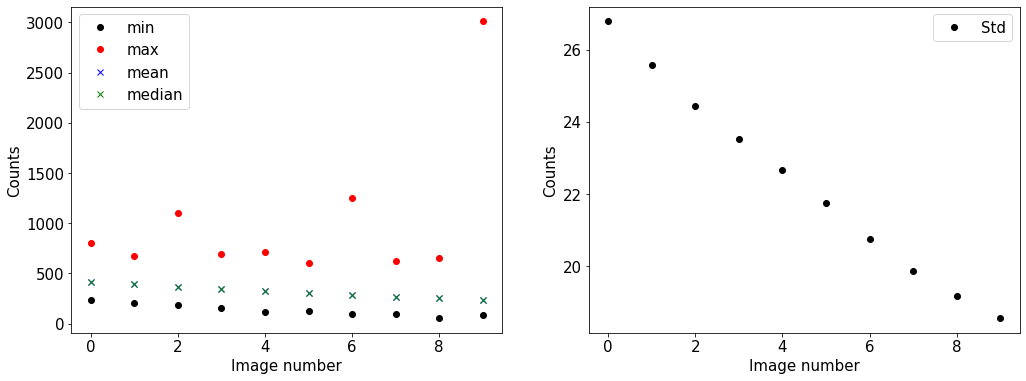

In [18]:
#Showing some of the stats on plots:
plt.figure(figsize=(17,6))

plt.subplot(1,2,1)
plt.plot(image_min,'ko',label='min')
plt.plot(image_max,'ro',label='max')
plt.plot(image_mean, 'bx', label='mean')
plt.plot(image_median,'gx',label='median')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()


plt.subplot(1,2,2)
plt.plot(image_stdev,'ko',label='Std')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()



plt.show()



In [19]:
#Normalising the flat images to the median:
for i in range(N_images[0]):
    image_concat[i] = image_concat[i] / np.median(image_concat[i])

In [20]:
flat_min = np.zeros(N_images[0])
flat_max = np.zeros(N_images[0])
flat_mean = np.zeros(N_images[0])
flat_median = np.zeros(N_images[0])
flat_stdev = np.zeros(N_images[0])

Flat_Blue_20_secs_010.fits
Min: 0.38107202680067026
Max: 12.597803833984738
Mean: 1.000364247544981
Median 1.0
Stdev: 0.07774728259201077


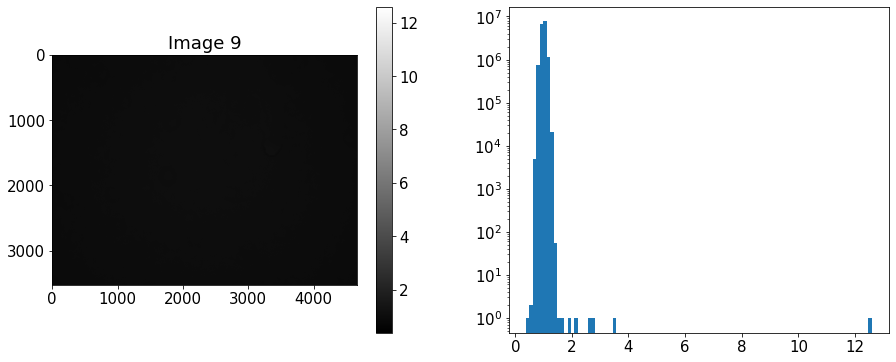

In [21]:
N_std = 0.2


for i in range(N_images[0]):
    clear_output(wait=True)

    plt.figure(figsize=(15,6))
    
    print(image_list[i])
    flat_min[i] = np.min(image_concat[i])
    flat_max[i] = np.max(image_concat[i])
    flat_mean[i] = np.mean(image_concat[i])
    flat_median[i] = np.median(image_concat[i])
    flat_stdev[i] = np.std(image_concat[i])

    
    
    print('Min:', flat_min[i] )
    print('Max:', flat_max[i] )    
    print('Mean:', flat_mean[i] )
    print('Median', flat_median[i] )
    print('Stdev:', flat_stdev[i] )


    
    plt.subplot(1,2,1)
    plt.imshow(image_concat[i], cmap='gray')
    plt.title("Image "+ str(i))
    plt.colorbar()


    plt.subplot(1,2,2)
    plt.hist(image_concat[i].flatten(),bins=100)
    plt.yscale('log')
  
    plt.show()
    
    time.sleep(1) #pause in secs


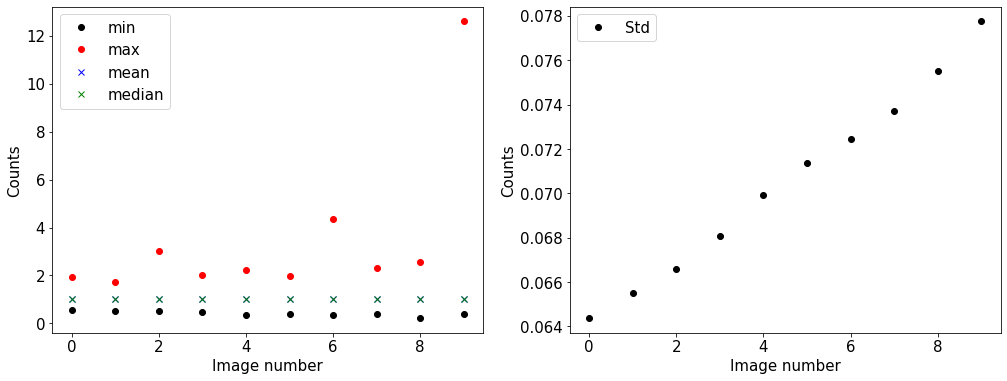

In [22]:
plt.figure(figsize=(17,6))

plt.subplot(1,2,1)
plt.plot(flat_min,'ko',label='min')
plt.plot(flat_max,'ro',label='max')
plt.plot(flat_mean, 'bx', label='mean')
plt.plot(flat_median,'gx',label='median')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()


plt.subplot(1,2,2)
plt.plot(flat_stdev,'ko',label='Std')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()



plt.show()



In [23]:
#Make a new array which is a plain 3D array of integers
all_data = np.zeros(N_images)
for i in range(N_images[0]):
    all_data[i,:,:] = image_concat[i]

In [24]:
NyPix = np.shape(all_data)[1]
NxPix = np.shape(all_data)[2]
print(NxPix,NyPix)

4656 3520


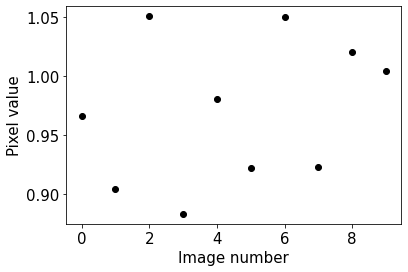

In [25]:
#Showing the varience due to noise in the flats:
x = int(random.randint(1, NxPix))
y = int(random.randint(1, NyPix))

plt.plot(all_data[:,y,x],'ko' )

plt.xlabel('Image number')
plt.ylabel('Pixel value')

plt.show()

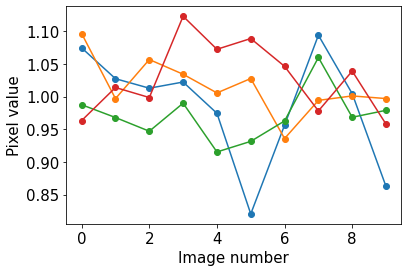

In [26]:
x_list = np.zeros(4)
y_list =  np.zeros(4)
x_list = [random.randint(1, NxPix),random.randint(1, NxPix),random.randint(1, NxPix),random.randint(1, NxPix)]
y_list = [random.randint(1, NyPix),random.randint(1, NyPix),random.randint(1, NyPix),random.randint(1, NyPix)]

for i in range(4):
    plt.plot(all_data[:,y_list[i],x_list[i]],'-o')



plt.xlabel('Image number')
plt.ylabel('Pixel value')

plt.show()

In [27]:
pixels_std = np.std(all_data, axis=0)

In [28]:
#Making a new array which each entry is the standard deviation of the flat divided by the number of flat images pixel by pixel:
np.shape(pixels_std)

(3520, 4656)

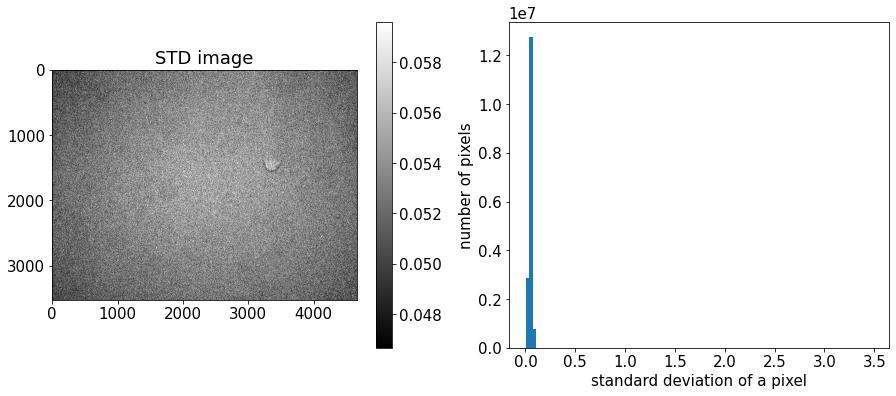

In [29]:
plt.figure(figsize=(15,6))

N_std = 0.5

std_mean = np.mean(pixels_std)
std_std = np.std(pixels_std)

plt.subplot(1,2,1)
plt.imshow(pixels_std, cmap='gray',
           vmin= std_mean - N_std*std_std, vmax=std_mean + N_std*std_std)
plt.title("STD image")
plt.colorbar()

plt.subplot(1,2,2)
plt.hist(pixels_std.flatten(),bins=100)
plt.xlabel('standard deviation of a pixel')
plt.ylabel('number of pixels')


plt.show()

In [30]:
#Computing overall uncertainty in the raw flat value and the median:
Uncertainty_flat = np.median(pixels_std)
print(Uncertainty_flat)
#The read noise should be 1.7 counts according to the ZWO camera manual
#For short time exposures the dark current can be zero and the noise is equal to the read noise

0.05254301493103733


In [31]:
print('Flat uncertainty: {0:.3f} counts'.format(Uncertainty_flat))


Flat uncertainty: 0.053 counts


In [32]:
#Combing the flat images to produce master-flat to reduce the uncertainty by root N where N is the number of images:
master_flat = np.median(all_data, axis=0)

Min: 0.3907548317810792
Max: 2.0655082058304144
Mean: 1.0003774714662776
Median 1.0000794320326842
Stdev: 0.046074104166806816
Total sum: 16395306.4251574


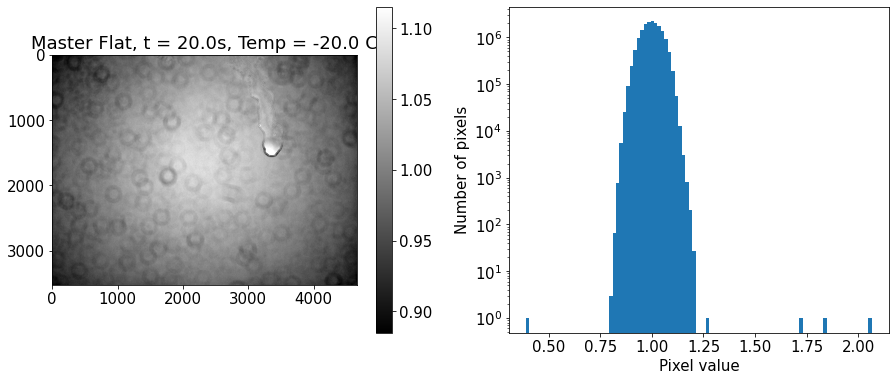

In [33]:
plt.figure(figsize=(15,6))
            
    
N_std = 2.5
    
print('Min:', np.min(master_flat) )
print('Max:', np.max(master_flat)  )    
print('Mean:', np.mean(master_flat)  )
print('Median', np.median(master_flat)  )
print('Stdev:', np.std(master_flat)  )
print('Total sum:',np.sum(master_flat))


    
plt.subplot(1,2,1)
plt.imshow(master_flat, cmap='gray', 
               vmin= np.median(master_flat) - N_std*np.std(master_flat), vmax=np.median(master_flat) + N_std*np.std(master_flat)) 
plt.title('Master Flat, t = '+str(exposure)+'s, Temp = '+str(camera_temp)+' C' )
plt.colorbar()


plt.subplot(1,2,2)
plt.hist(master_flat.flatten(),bins= 100)
plt.yscale('log')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
  
plt.show()
    


In [34]:
#Save image and stats to a file:
outfile = filepath+'master_flat_blue.fits'

hdu = fits.PrimaryHDU(master_flat)
hdu.writeto(outfile, overwrite=True)

In [35]:
stats_data = np.zeros([N_images[0]+2,5])
stats_data[0:N_images[0],0] = image_min
stats_data[0:N_images[0],1] = image_max
stats_data[0:N_images[0],2] = image_mean
stats_data[0:N_images[0],3] = image_median
stats_data[0:N_images[0],4] = image_stdev


# Add master stats at the end
stats_data[-1,0] = np.min(master_flat)
stats_data[-1,1] = np.max(master_flat)
stats_data[-1,2] = np.mean(master_flat)
stats_data[-1,3] = np.median(master_flat)
stats_data[-1,4] = np.std(master_flat)

# Add  stats image at the end
stats_data[-2,0] = np.min(pixels_std)
stats_data[-2,1] = np.max(pixels_std)
stats_data[-2,2] = np.mean(pixels_std)
stats_data[-2,3] = np.median(pixels_std)
stats_data[-2,4] = np.std(pixels_std)

df_stats = pd.DataFrame(data=stats_data,columns=['min','max','mean','median','std'])

In [36]:
image_list.append(filepath+'std_image')
image_list.append(filepath+'master_flat_blue.fits')

df_stats['filename'] = image_list

In [37]:
camera_temp = []
exposure = []
camera_filter = []

FILTER  = 'Luminance'

for n in range(N_images[0]):
    camera_temp.append(image_hdr[n]["CCD-TEMP"])
    exposure.append(image_hdr[n]["EXPTIME "])
    camera_filter.append(image_hdr[n]["FILTER "])

# need to do something for the std and master images etc.

mean_temp = np.mean(camera_temp)
mean_exposure = np.mean(exposure)


camera_temp.append(mean_temp)
camera_temp.append(mean_temp)
exposure.append(mean_exposure)
exposure.append(mean_exposure)
camera_filter.append(image_hdr[n]["FILTER "])
camera_filter.append(image_hdr[n]["FILTER "])

df_stats['Temp'] = camera_temp
df_stats['Exposure/s'] = exposure
df_stats['Filter '] = camera_filter

In [38]:
what_list = []
for i in range(N_images[0]):
    what_list.append('flat')
    
what_list.append('Std_image')
what_list.append('master')



# Make column of "what"
df_stats['what'] = what_list

In [39]:
df_stats.to_csv(filepath+'flat_stats_blue.csv') #write to file.